In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import eigvalsh, eigh

import algo
import utils
import interactions
import dicke

# Plotting the max u_k

(10, 7)


/Users/jroman/Desktop/Code/long_range_ising/dicke.py:9: RuntimeWarning: overflow encountered in cosh
  return beta*np.sum(ws * uks**2) - 1/N*np.sum(np.log(2 * np.cosh(0.5 * beta * np.sqrt(wz**2 + 4*aux**2))))
/Users/jroman/miniconda3/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/jroman/Desktop/Code/long_range_ising/dicke.py:9: RuntimeWarning: overflow encountered in cosh
  return beta*np.sum(ws * uks**2) - 1/N*np.sum(np.log(2 * np.cosh(0.5 * beta * np.sqrt(wz**2 + 4*aux**2))))
/Users/jroman/miniconda3/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/jroman/Desktop/Code/long_range_ising/dicke.py:9: RuntimeWarning: overflow encountered in cosh
  return beta*np.sum(ws * uks**2) - 1/N*np.sum(np.log(2 * np.cosh(0.5 * beta * np.sqrt(wz**2 + 4*aux**2))))
/Users/jroman/miniconda3/lib/python3.10/site-packages/s

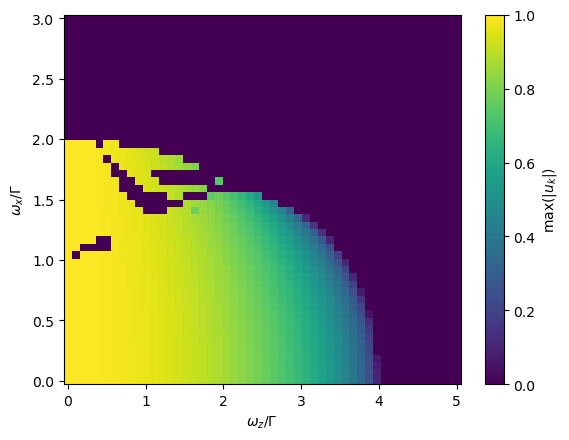

In [173]:
N = 10
beta = 10
wzs = np.linspace(0, 5, 50)
wxs = np.linspace(0, 3, 50)
alpha = 0.3
M = np.sqrt(N) * np.log(N)
#M = round(N**np.tanh(2*alpha**(1/2)))

J = interactions.powerlaw_pbc_afm(N, alpha)
J = interactions.shift(J, 0.0)
J = interactions.rescale(J)
ws, lams = utils.dicke_from_ising(J, 1e-6)
ws, lams = utils.truncate_dicke(ws, lams, M)

print(lams.shape)

us = np.empty((len(wzs), len(wxs)))
for i, wz in enumerate(wzs):
    for j, wx in enumerate(wxs):
        gs = wx * np.ones(N) / 2
        uks1 = minimize(dicke.uks_f, x0=np.array([0.0]*len(ws)), args=(beta, wz, ws, np.sqrt(N) * lams, gs, N)).x
        uks2 = minimize(dicke.uks_f, x0=np.array([2.0]*len(ws)), args=(beta, wz, ws, np.sqrt(N) * lams, gs, N)).x
        
        if dicke.uks_f(uks1, beta, wz, ws, np.sqrt(N) * lams, gs, N) < dicke.uks_f(uks2, beta, wz, ws, np.sqrt(N) * lams, gs, N):
            uks = uks1
        else:
            uks = uks2
            
        us[i, j] = np.amax(np.abs(uks))


plt.pcolormesh(wzs, wxs, us.T, cmap='viridis')
plt.colorbar(label=r'$\max(|u_k|)$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

In [3]:
def kernel(xs, λs, gs):
    return 2*np.sum(λs*xs, axis=1) + gs

def mags_f(uks, beta, wz, λs, gs):
    aux = kernel(uks, λs, gs)
    return 0.5 * np.tanh(0.5 * beta * np.sqrt(wz**2 + 4*aux**2)) * 4 * aux / np.sqrt(wz**2 + 4*aux**2)

def secnd_order_line(wz):
    return np.sqrt((4 * wz**2)**(2/3) - wz**2)

# Magnetizations

/var/folders/54/wwvz2d1s1v7ck12y_l10q3pw0000gn/T/ipykernel_43145/3448075039.py:9: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((4 * wz**2)**(2/3) - wz**2)


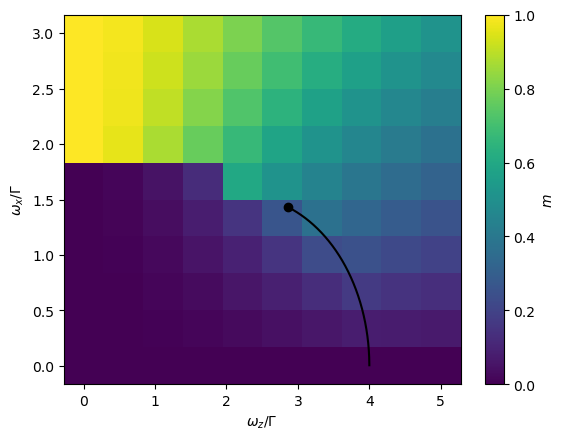

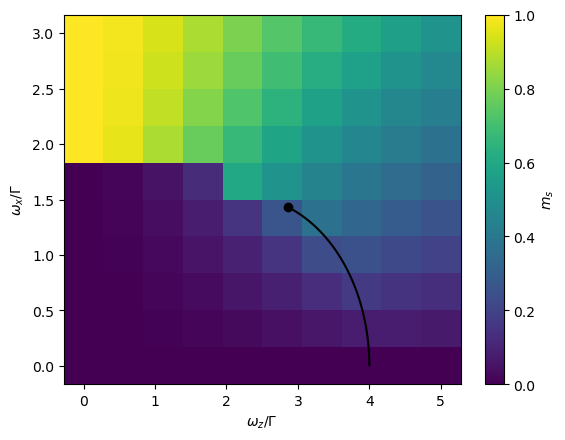

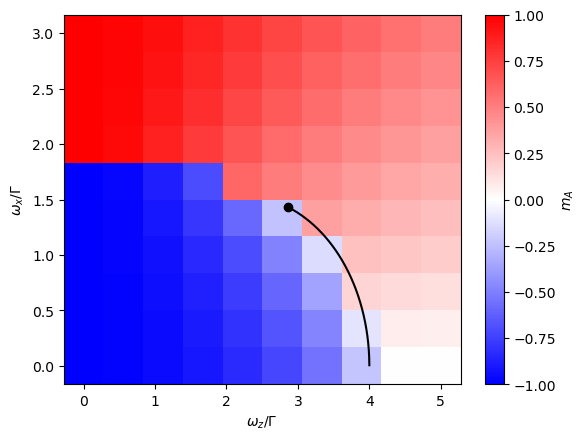

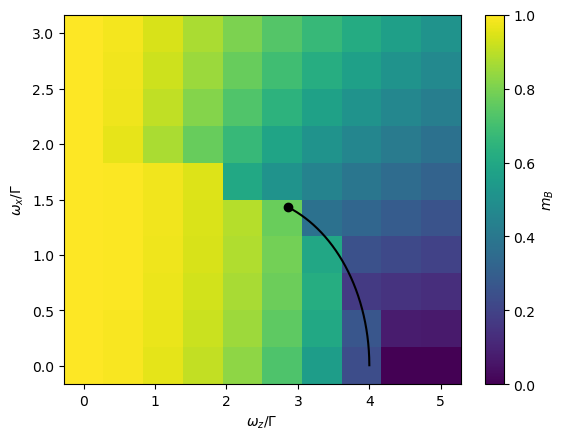

In [8]:

N = 10
beta = 10
wzs = np.linspace(0, 5, 10)
wxs = np.linspace(0, 3, 10)
alpha = 0.3
M = round(N**np.tanh(2*alpha**(1/2)))

J = interactions.powerlaw_pbc_afm(N, alpha)
J = interactions.shift(J, 0.0)
J = interactions.rescale(J)
ws, lams = utils.dicke_from_ising(J, 1e-6)
ws, lams = utils.truncate_dicke(ws, lams, M)

v_stagger = np.ones(N)
v_stagger[1::2] = 1

mag = np.empty((len(wzs), len(wxs)))
stmag = np.empty((len(wzs), len(wxs)))
magA = np.empty((len(wzs), len(wxs)))
magB = np.empty((len(wzs), len(wxs)))
for i, wz in enumerate(wzs):
    for j, wx in enumerate(wxs):
        gs = wx * np.ones(N) / 2
        uks1 = minimize(dicke.uks_f, x0=np.array([0.0]*len(ws)), args=(beta, wz, ws, np.sqrt(N) * lams, gs, N)).x
        uks2 = minimize(dicke.uks_f, x0=np.array([2.0]*len(ws)), args=(beta, wz, ws, np.sqrt(N) * lams, gs, N)).x
        
        if dicke.uks_f(uks1, beta, wz, ws, np.sqrt(N) * lams, gs, N) < dicke.uks_f(uks2, beta, wz, ws, np.sqrt(N) * lams, gs, N):
            uks = uks1
        else:
            uks = uks2
            
        mags = mags_f(uks, beta, wz, np.sqrt(N) * lams, gs)
        
        mag[i, j] = np.sum(mags) / N
        stmag[i, j] = np.sum(mags * v_stagger) / N
        magA[i, j] = np.sum(mags[::2]) * 2 / N
        magB[i, j] = np.sum(mags[1::2]) * 2 / N

supercritical_pt = 4 * (4/5)**(3/2)
wzs_dense = np.linspace(supercritical_pt, 4, 100000)

plt.pcolormesh(wzs, wxs, mag.T, cmap='viridis')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'$m$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, stmag.T, cmap='viridis')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'$m_s$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, magA.T, cmap='bwr')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'$m_A$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, magB.T, cmap='viridis')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'$m_B$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

In [4]:
def Ys_f(uks, beta, wz, λs, gs):
    aux = kernel(uks, λs, gs)
    eps = 0.5 * np.sqrt(wz**2 + 4*aux**2)
    
    return (1 - np.tanh(beta * eps)**2)*beta*(aux / eps)**2 + np.tanh(beta * eps)*(1/eps - (aux**2 / eps**3)) 

def hessian(uks, beta, wz, ws, λs, gs, N):
    H = np.diag(-2 * beta * ws)
    Ys = Ys_f(uks, beta, wz, λs, gs)
    H += 4/N * beta * np.dot(λs.T, np.dot(np.diag(Ys), λs))
    
    return H

# Check eigenvalues of Hessian

(10, 6)


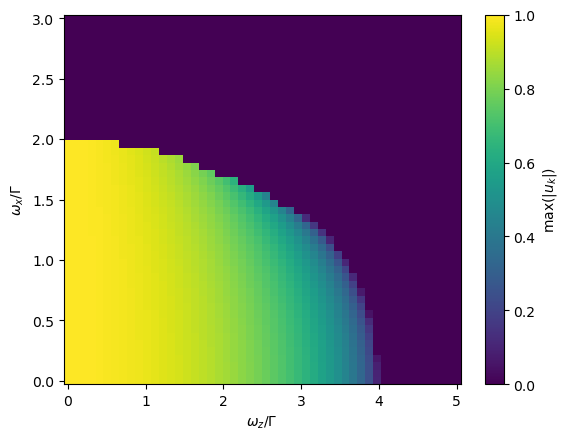

/var/folders/54/wwvz2d1s1v7ck12y_l10q3pw0000gn/T/ipykernel_90243/3448075039.py:9: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((4 * wz**2)**(2/3) - wz**2)


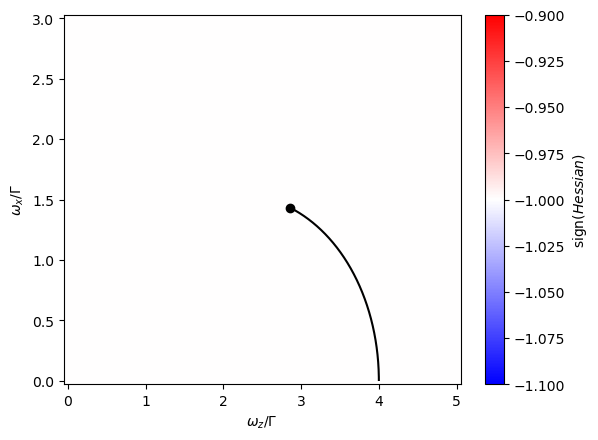

In [114]:
N = 10
beta = 10
wzs = np.linspace(0, 5, 50)
wxs = np.linspace(0, 3, 50)
alpha = 0.3
M = round(N**np.tanh(2*alpha**(1/2)))

J = interactions.powerlaw_pbc_afm(N, alpha)
J = interactions.shift(J, 0.0)
J = interactions.rescale(J)
ws, lams = utils.dicke_from_ising(J, 1e-6)
ws, lams = utils.truncate_dicke(ws, lams, M)

print(lams.shape)

us = np.empty((len(wzs), len(wxs)))
hessian_sign = np.empty((len(wzs), len(wxs)))
for i, wz in enumerate(wzs):
    for j, wx in enumerate(wxs):
        gs = wx * np.ones(N) / 2
        uks1 = minimize(dicke.uks_f, x0=np.array([0.0]*len(ws)), args=(beta, wz, ws, np.sqrt(N) * lams, gs, N)).x
        uks2 = minimize(dicke.uks_f, x0=np.array([2.0]*len(ws)), args=(beta, wz, ws, np.sqrt(N) * lams, gs, N)).x
        
        if dicke.uks_f(uks1, beta, wz, ws, np.sqrt(N) * lams, gs, N) < dicke.uks_f(uks2, beta, wz, ws, np.sqrt(N) * lams, gs, N):
            uks = uks1
        else:
            uks = uks2
            
        H = hessian(uks, beta, wz, ws, np.sqrt(N) * lams, gs, N)
        vals = eigvalsh(H)
        #print(np.amax(vals))
        #assert np.amax(vals) < 0
            
        us[i, j] = np.amax(np.abs(uks))
        hessian_sign[i, j] = np.amax(vals) / np.abs(np.amax(vals))


plt.pcolormesh(wzs, wxs, us.T, cmap='viridis')
plt.colorbar(label=r'$\max(|u_k|)$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

supercritical_pt = 4 * (4/5)**(3/2)
wzs_dense = np.linspace(supercritical_pt, 4, 100000)

plt.pcolormesh(wzs, wxs, hessian_sign, cmap='bwr')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'${\rm sign}(Hessian)$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

# Detect and extract phase transition

(10, 6)


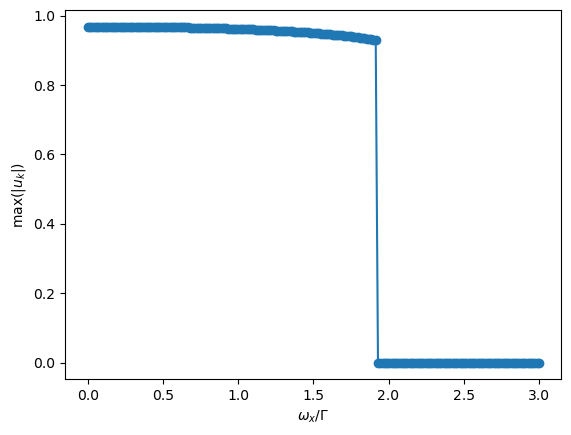

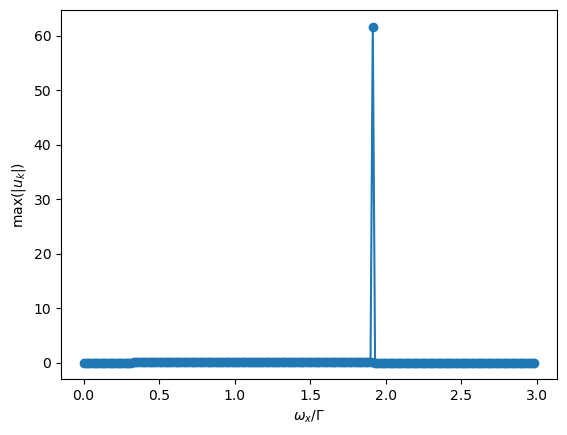

In [115]:
N = 10
beta = 10
wz = 1
wxs = np.linspace(0, 3, 200)
alpha = 0.3
M = round(N**np.tanh(2*alpha**(1/2)))

J = interactions.powerlaw_pbc_afm(N, alpha)
J = interactions.shift(J, 0.0)
J = interactions.rescale(J)
ws, lams = utils.dicke_from_ising(J, 1e-6)
ws, lams = utils.truncate_dicke(ws, lams, M)

print(lams.shape)

us = np.empty(len(wxs))
for j, wx in enumerate(wxs):
    gs = wx * np.ones(N) / 2
    uks1 = minimize(dicke.uks_f, x0=np.array([0.0]*len(ws)), args=(beta, wz, ws, np.sqrt(N) * lams, gs, N)).x
    uks2 = minimize(dicke.uks_f, x0=np.array([2.0]*len(ws)), args=(beta, wz, ws, np.sqrt(N) * lams, gs, N)).x
    
    if dicke.uks_f(uks1, beta, wz, ws, np.sqrt(N) * lams, gs, N) < dicke.uks_f(uks2, beta, wz, ws, np.sqrt(N) * lams, gs, N):
        uks = uks1
    else:
        uks = uks2
        
    us[j] = np.amax(np.abs(uks))


plt.plot(wxs, us, marker='o')
plt.ylabel(r'$\max(|u_k|)$')
plt.xlabel(r'$\omega_x/\Gamma$')
plt.show()

plt.plot(wxs[:-1], np.abs((us[1:] - us[:-1])/ (wxs[1] - wxs[0])), marker='o')
plt.ylabel(r'$\max(|u_k|)$')
plt.xlabel(r'$\omega_x/\Gamma$')
plt.show()


(10, 6)


/var/folders/54/wwvz2d1s1v7ck12y_l10q3pw0000gn/T/ipykernel_90243/3448075039.py:9: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((4 * wz**2)**(2/3) - wz**2)


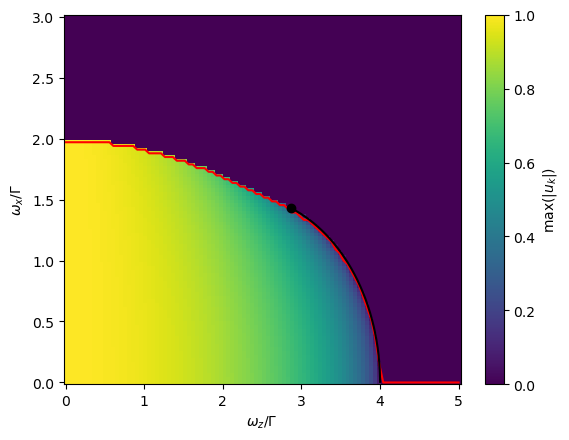

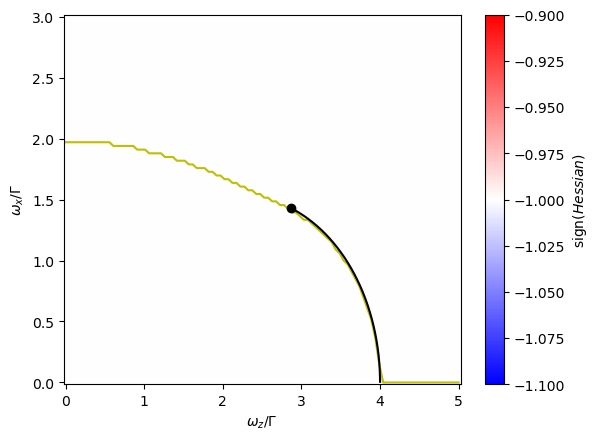

In [116]:
N = 10
beta = 10
wzs = np.linspace(0, 5, 100)
wxs = np.linspace(0, 3, 100)
alpha = 0.3
M = round(N**np.tanh(2*alpha**(1/2)))

J = interactions.powerlaw_pbc_afm(N, alpha)
J = interactions.shift(J, 0.0)
J = interactions.rescale(J)
ws, lams = utils.dicke_from_ising(J, 1e-6)
ws, lams = utils.truncate_dicke(ws, lams, M)

print(lams.shape)

us = np.empty((len(wzs), len(wxs)))
hessian_sign = np.empty((len(wzs), len(wxs)))
wxcs = []
for i, wz in enumerate(wzs):
    for j, wx in enumerate(wxs):
        gs = wx * np.ones(N) / 2
        uks1 = minimize(dicke.uks_f, x0=np.array([0.0]*len(ws)), args=(beta, wz, ws, np.sqrt(N) * lams, gs, N)).x
        uks2 = minimize(dicke.uks_f, x0=np.array([2.0]*len(ws)), args=(beta, wz, ws, np.sqrt(N) * lams, gs, N)).x
        
        if dicke.uks_f(uks1, beta, wz, ws, np.sqrt(N) * lams, gs, N) < dicke.uks_f(uks2, beta, wz, ws, np.sqrt(N) * lams, gs, N):
            uks = uks1
        else:
            uks = uks2
        
        #uks[:1] = 0
        H = hessian(uks, beta, wz, ws, np.sqrt(N) * lams, gs, N)
        vals = eigvalsh(H)
        #print(np.amax(vals))
        #assert np.amax(vals) < 0
            
        us[i, j] = np.amax(np.abs(uks))
        hessian_sign[i, j] = np.amax(vals) / np.abs(np.amax(vals))
    
    wxcs.append(wxs[np.argmax(np.abs((us[i][1:] - us[i][:-1])/ (wxs[1] - wxs[0])))])

supercritical_pt = 4 * (4/5)**(3/2)
wzs_dense = np.linspace(supercritical_pt, 4, 100000)

plt.pcolormesh(wzs, wxs, us.T, cmap='viridis')
plt.plot(wzs, wxcs, c='r')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'$\max(|u_k|)$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, hessian_sign, cmap='bwr')
plt.plot(wzs, wxcs, c='y')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'${\rm sign}(Hessian)$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

In [5]:
def uk_f(u, beta, wz, w0, g):
    return beta*w0*u**2 - 0.5*np.log(2 * np.cosh(0.5 * beta * np.sqrt(wz**2 + 4*(2*u + g)**2))) - 0.5*np.log(2 * np.cosh(0.5 * beta * np.sqrt(wz**2 + 4*(-2*u + g)**2)))

# Assume inhomogeneous solution

(10, 6)


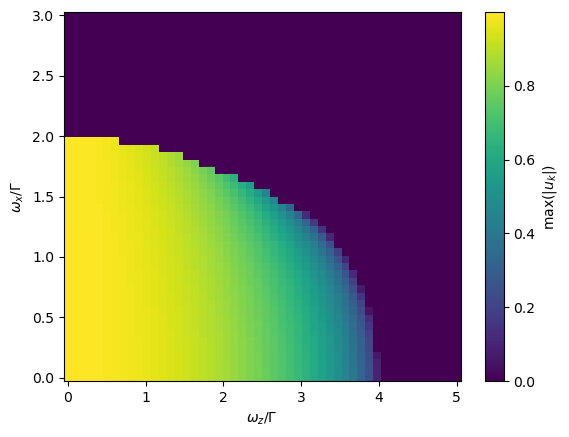

/var/folders/54/wwvz2d1s1v7ck12y_l10q3pw0000gn/T/ipykernel_90243/3448075039.py:9: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((4 * wz**2)**(2/3) - wz**2)


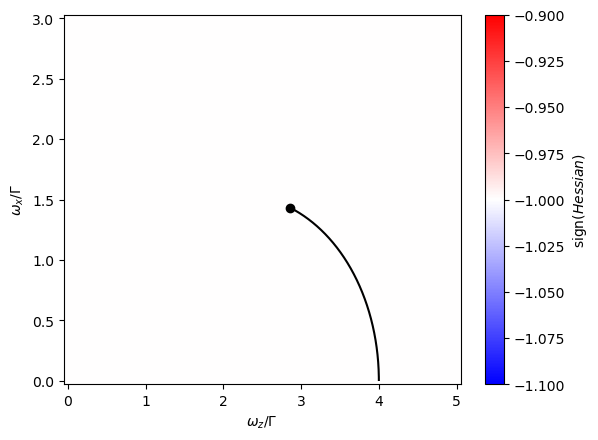

In [149]:
N = 10
beta = 10
wzs = np.linspace(0, 5, 50)
wxs = np.linspace(0, 3, 50)
alpha = 0.3
M = round(N**np.tanh(2*alpha**(1/2)))

print(lams.shape)

us_anti = np.empty((len(wzs), len(wxs)))
hessian_sign = np.empty((len(wzs), len(wxs)))
for i, wz in enumerate(wzs):
    for j, wx in enumerate(wxs):
        gs = wx * np.ones(N) / 2
        u1 = minimize(uk_f, x0=0.0, args=(beta, wz, 1, gs[0])).x[0]
        u2 = minimize(uk_f, x0=2.0, args=(beta, wz, 1, gs[0])).x[0]
        
        if uk_f(u1, beta, wz, 1, gs[0]) < uk_f(u2, beta, wz, 1, gs[0]):
            u = u1
        else:
            u = u2
        
        uks = np.zeros(M)
        uks[-1] = u
        H = hessian(uks, beta, wz, ws, np.sqrt(N) * lams, gs, N)
        vals = eigvalsh(H)
        #print(np.amax(vals))
        #assert np.amax(vals) < 0
            
        us_anti[i, j] = np.abs(u)
        hessian_sign[i, j] = np.amax(vals) / np.abs(np.amax(vals))


plt.pcolormesh(wzs, wxs, us_anti.T, cmap='viridis')
plt.colorbar(label=r'$\max(|u_k|)$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

supercritical_pt = 4 * (4/5)**(3/2)
wzs_dense = np.linspace(supercritical_pt, 4, 100000)

plt.pcolormesh(wzs, wxs, hessian_sign, cmap='bwr')
plt.plot(wzs_dense, secnd_order_line(wzs_dense), c='k')
plt.plot(supercritical_pt, secnd_order_line(supercritical_pt), c='k', lw=0, marker='o')
plt.colorbar(label=r'${\rm sign}(Hessian)$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

# Check differences between general solution and solution assuming inhomogeneity

(10, 6)


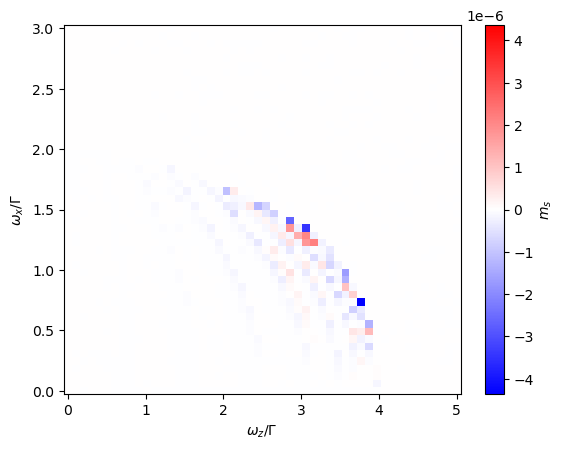

In [150]:
N = 10
beta = 10
wzs = np.linspace(0, 5, 50)
wxs = np.linspace(0, 3, 50)
alpha = 0.3
M = round(N**np.tanh(2*alpha**(1/2)))

J = interactions.powerlaw_pbc_afm(N, alpha)
J = interactions.shift(J, 0.0)
J = interactions.rescale(J)
ws, lams = utils.dicke_from_ising(J, 1e-6)
ws, lams = utils.truncate_dicke(ws, lams, M)

print(lams.shape)

v_stagger = np.ones(N)
v_stagger[1::2] = 1

mags = np.empty((len(wzs), len(wxs)))
for i, wz in enumerate(wzs):
    for j, wx in enumerate(wxs):
        gs = wx * np.ones(N) / 2
        uks1 = minimize(dicke.uks_f, x0=np.array([0.0]*len(ws)), args=(beta, wz, ws, np.sqrt(N) * lams, gs, N)).x
        uks2 = minimize(dicke.uks_f, x0=np.array([2.0]*len(ws)), args=(beta, wz, ws, np.sqrt(N) * lams, gs, N)).x
        
        if dicke.uks_f(uks1, beta, wz, ws, np.sqrt(N) * lams, gs, N) < dicke.uks_f(uks2, beta, wz, ws, np.sqrt(N) * lams, gs, N):
            uks = uks1
        else:
            uks = uks2
            
        ms = mags_f(uks, beta, wz, np.sqrt(N) * lams, gs)
        mags[i, j] = np.sum(ms * v_stagger) / N
        
mags_anti = np.empty((len(wzs), len(wxs)))
for i, wz in enumerate(wzs):
    for j, wx in enumerate(wxs):
        gs = wx * np.ones(N) / 2
        u1 = minimize(uk_f, x0=0.0, args=(beta, wz, 1, gs[0])).x[0]
        u2 = minimize(uk_f, x0=2.0, args=(beta, wz, 1, gs[0])).x[0]
        
        if uk_f(u1, beta, wz, 1, gs[0]) < uk_f(u2, beta, wz, 1, gs[0]):
            u = u1
        else:
            u = u2
        
        uks = np.zeros(M)
        uks[-1] = u
        ms = mags_f(uks, beta, wz, np.sqrt(N) * lams, gs)
        mags_anti[i, j] = np.sum(ms * v_stagger) / N

plt.pcolormesh(wzs, wxs, mags_anti.T - mags.T, cmap='bwr', vmin=-np.amax(np.abs(mags_anti.T - mags.T)), vmax=np.amax(np.abs(mags_anti.T - mags.T)))
plt.colorbar(label=r'$m_s$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

# Random search around inhomogeneous solution

(10, 6)


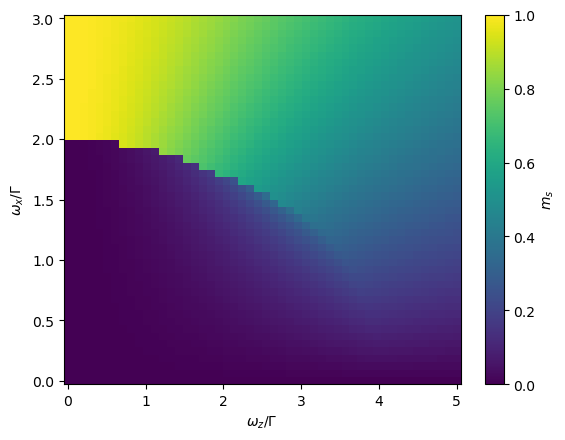

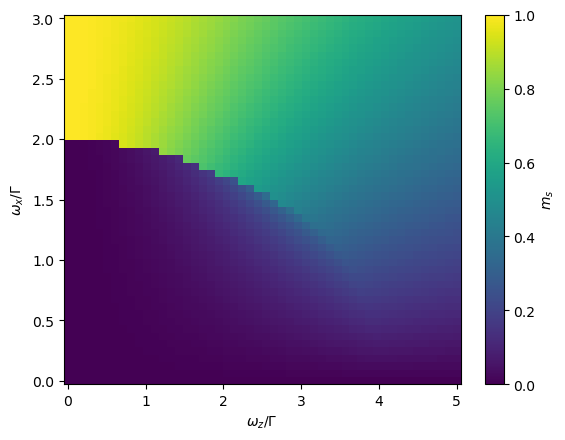

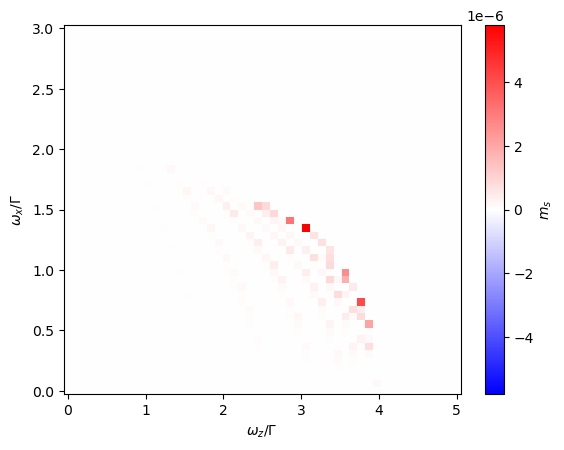

In [151]:
N = 10
beta = 10
wzs = np.linspace(0, 5, 50)
wxs = np.linspace(0, 3, 50)
alpha = 0.3
M = round(N**np.tanh(2*alpha**(1/2)))

J = interactions.powerlaw_pbc_afm(N, alpha)
J = interactions.shift(J, 0.0)
J = interactions.rescale(J)
ws, lams = utils.dicke_from_ising(J, 1e-6)
ws, lams = utils.truncate_dicke(ws, lams, M)

print(lams.shape)
        
mags = np.empty((len(wzs), len(wxs)))
mags_anti = np.empty((len(wzs), len(wxs)))
for i, wz in enumerate(wzs):
    for j, wx in enumerate(wxs):
        gs = wx * np.ones(N) / 2
        u1 = minimize(uk_f, x0=0.0, args=(beta, wz, 1, gs[0])).x[0]
        u2 = minimize(uk_f, x0=2.0, args=(beta, wz, 1, gs[0])).x[0]
        
        if uk_f(u1, beta, wz, 1, gs[0]) < uk_f(u2, beta, wz, 1, gs[0]):
            u = u1
        else:
            u = u2
        
        anti_sol = np.zeros(M)
        anti_sol[-1] = u
        best_sol = np.copy(anti_sol)
        
        for _ in range(20):
            fluctuations = u*0.1 * 2*(np.random.rand(M) - 0.5)
            intial_cond = anti_sol + fluctuations
            new_sol = minimize(dicke.uks_f, x0=intial_cond, args=(beta, wz, ws, np.sqrt(N) * lams, gs, N)).x
            
            if dicke.uks_f(new_sol, beta, wz, ws, np.sqrt(N) * lams, gs, N) < dicke.uks_f(best_sol, beta, wz, ws, np.sqrt(N) * lams, gs, N):
                best_sol = np.copy(new_sol)
                
        ms = mags_f(best_sol, beta, wz, np.sqrt(N) * lams, gs)
        mags[i, j] = np.sum(ms * v_stagger) / N
        
        ms = mags_f(anti_sol, beta, wz, np.sqrt(N) * lams, gs)
        mags_anti[i, j] = np.sum(ms * v_stagger) / N

plt.pcolormesh(wzs, wxs, mags.T, cmap='viridis')
plt.colorbar(label=r'$m_s$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, mags_anti.T, cmap='viridis')
plt.colorbar(label=r'$m_s$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, mags.T - mags_anti.T, cmap='bwr', vmin=-np.amax(np.abs(mags.T - mags_anti.T)), vmax=np.amax(np.abs(mags.T - mags_anti.T)))
plt.colorbar(label=r'$m_s$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

# Basinhopping search around inhomogeneous solution

In [9]:
from scipy.optimize import basinhopping

N = 10
beta = 10
wzs = np.linspace(0, 5, 50)
wxs = np.linspace(0, 3, 50)
alpha = 0.3
M = round(N**np.tanh(2*alpha**(1/2)))

J = interactions.powerlaw_pbc_afm(N, alpha)
J = interactions.shift(J, 0.0)
J = interactions.rescale(J)
ws, lams = utils.dicke_from_ising(J, 1e-6)
ws, lams = utils.truncate_dicke(ws, lams, M)

print(lams.shape)
        
mags = np.empty((len(wzs), len(wxs)))
mags_anti = np.empty((len(wzs), len(wxs)))
for i, wz in enumerate(wzs):
    for j, wx in enumerate(wxs):
        gs = wx * np.ones(N) / 2
        u1 = minimize(uk_f, x0=0.0, args=(beta, wz, 1, gs[0])).x[0]
        u2 = minimize(uk_f, x0=2.0, args=(beta, wz, 1, gs[0])).x[0]
        
        if uk_f(u1, beta, wz, 1, gs[0]) < uk_f(u2, beta, wz, 1, gs[0]):
            u = u1
        else:
            u = u2
        
        anti_sol = np.zeros(M)
        anti_sol[-1] = u
        best_sol = np.copy(anti_sol)
        
        sol = basinhopping(dicke.uks_f, x0=anti_sol, niter=10, minimizer_kwargs={'args': (beta, wz, ws, np.sqrt(N) * lams, gs, N)}).x
                
        if dicke.uks_f(sol, beta, wz, ws, np.sqrt(N) * lams, gs, N) < dicke.uks_f(anti_sol, beta, wz, ws, np.sqrt(N) * lams, gs, N):
            best_sol = np.copy(sol)
                
        ms = mags_f(best_sol, beta, wz, np.sqrt(N) * lams, gs)
        mags[i, j] = np.sum(ms * v_stagger) / N
        
        ms = mags_f(anti_sol, beta, wz, np.sqrt(N) * lams, gs)
        mags_anti[i, j] = np.sum(ms * v_stagger) / N

plt.pcolormesh(wzs, wxs, mags.T, cmap='viridis')
plt.colorbar(label=r'$m_s$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, mags_anti.T, cmap='viridis')
plt.colorbar(label=r'$m_s$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, mags.T - mags_anti.T, cmap='bwr', vmin=-np.amax(np.abs(mags.T - mags_anti.T)), vmax=np.amax(np.abs(mags.T - mags_anti.T)))
plt.colorbar(label=r'$m_s$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

(10, 6)


/Users/jroman/Desktop/Code/long_range_ising/dicke.py:9: RuntimeWarning: overflow encountered in cosh
  return beta*np.sum(ws * uks**2) - 1/N*np.sum(np.log(2 * np.cosh(0.5 * beta * np.sqrt(wz**2 + 4*aux**2))))
/Users/jroman/miniconda3/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/jroman/Desktop/Code/long_range_ising/dicke.py:9: RuntimeWarning: overflow encountered in cosh
  return beta*np.sum(ws * uks**2) - 1/N*np.sum(np.log(2 * np.cosh(0.5 * beta * np.sqrt(wz**2 + 4*aux**2))))
/Users/jroman/miniconda3/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


KeyboardInterrupt: 

# Brute force search around inhomogeneous solution

In [174]:
from scipy.optimize import brute

N = 10
beta = 10
wzs = np.linspace(0, 5, 50)
wxs = np.linspace(0, 3, 50)
alpha = 0.5
M = round(N**np.tanh(2*alpha**(1/2)))

J = interactions.powerlaw_pbc_afm(N, alpha)
J = interactions.shift(J, 0.0)
J = interactions.rescale(J)
ws, lams = utils.dicke_from_ising(J, 1e-6)
ws, lams = utils.truncate_dicke(ws, lams, M)

print(lams.shape)
        
mags = np.empty((len(wzs), len(wxs)))
mags_anti = np.empty((len(wzs), len(wxs)))
for i, wz in enumerate(wzs):
    for j, wx in enumerate(wxs):
        gs = wx * np.ones(N) / 2
        u1 = minimize(uk_f, x0=0.0, args=(beta, wz, 1, gs[0])).x[0]
        u2 = minimize(uk_f, x0=2.0, args=(beta, wz, 1, gs[0])).x[0]
        
        if uk_f(u1, beta, wz, 1, gs[0]) < uk_f(u2, beta, wz, 1, gs[0]):
            u = u1
        else:
            u = u2
        
        anti_sol = np.zeros(M)
        anti_sol[-1] = u
        best_sol = np.copy(anti_sol)
        
        spread = 0.05 * u
        u0_range = (u - spread, u + spread)
        uk_range = (-spread, spread)
        
        sol = brute(dicke.uks_f, ranges=tuple([uk_range]*(M-1) + [u0_range]), Ns=5, args=(beta, wz, ws, np.sqrt(N) * lams, gs, N))[0]
        
        if dicke.uks_f(sol, beta, wz, ws, np.sqrt(N) * lams, gs, N) < dicke.uks_f(anti_sol, beta, wz, ws, np.sqrt(N) * lams, gs, N):
            best_sol = np.copy(sol)
                
        ms = mags_f(best_sol, beta, wz, np.sqrt(N) * lams, gs)
        mags[i, j] = np.sum(ms * v_stagger) / N
        
        ms = mags_f(anti_sol, beta, wz, np.sqrt(N) * lams, gs)
        mags_anti[i, j] = np.sum(ms * v_stagger) / N

plt.pcolormesh(wzs, wxs, mags.T, cmap='viridis')
plt.colorbar(label=r'$m_s$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, mags_anti.T, cmap='viridis')
plt.colorbar(label=r'$m_s$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, mags.T - mags_anti.T, cmap='bwr', vmin=-np.amax(np.abs(mags.T - mags_anti.T)), vmax=np.amax(np.abs(mags.T - mags_anti.T)))
plt.colorbar(label=r'$m_s$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

(10, 8)


KeyboardInterrupt: 

# Educated guess search

(10, 6)
[0.         0.         0.         0.         0.         0.99999999]
[0.         0.         0.         0.         0.         0.99999999]
[0.         0.         0.         0.         0.         0.99999999]
[0.         0.         0.         0.         0.         0.99999999]
[0.         0.         0.         0.         0.         0.99999999]
[0.         0.         0.         0.         0.         0.99999999]
[0.         0.         0.         0.         0.         0.99999999]
[0.         0.         0.         0.         0.         0.99999999]
[0.         0.         0.         0.         0.         0.99999999]
[0.         0.         0.         0.         0.         0.99999999]
[0.         0.         0.         0.         0.         0.99999999]
[0.         0.         0.         0.         0.         0.99999999]
[0.         0.         0.         0.         0.         0.99999999]
[0.         0.         0.         0.         0.         0.99999999]
[0.         0.         0.         0.    

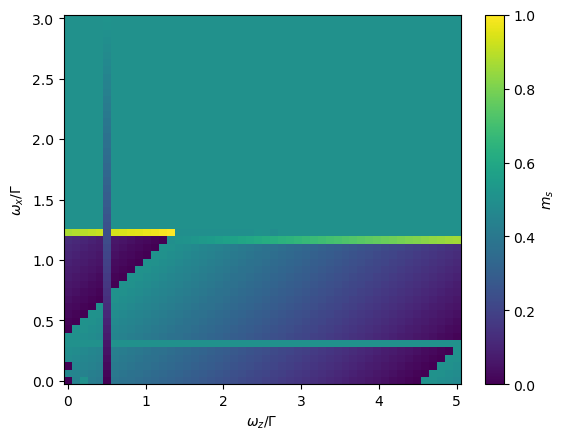

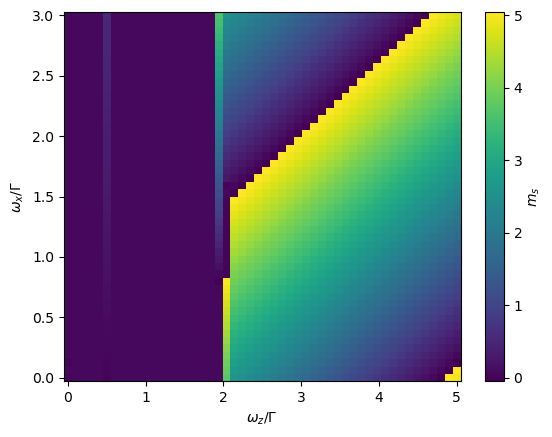

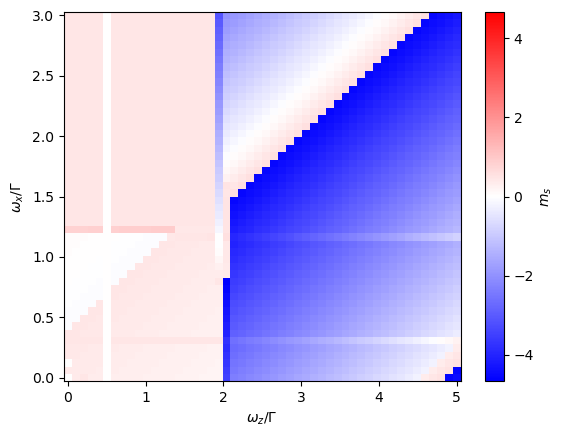

In [166]:
N = 10
beta = 10
wzs = np.linspace(0, 5, 50)
wxs = np.linspace(0, 3, 50)
alpha = 0.3
M = round(N**np.tanh(2*alpha**(1/2)))

J = interactions.powerlaw_pbc_afm(N, alpha)
J = interactions.shift(J, 0.0)
J = interactions.rescale(J)
ws, lams = utils.dicke_from_ising(J, 1e-6)
ws, lams = utils.truncate_dicke(ws, lams, M)

print(lams.shape)
        
mags = np.empty((len(wzs), len(wxs)))
mags_anti = np.empty((len(wzs), len(wxs)))
for i, wz in enumerate(wzs):
    for j, wx in enumerate(wxs):
        gs = wx * np.ones(N) / 2
        u1 = minimize(uk_f, x0=0.0, args=(beta, wz, 1, gs[0])).x[0]
        u2 = minimize(uk_f, x0=2.0, args=(beta, wz, 1, gs[0])).x[0]
        
        if uk_f(u1, beta, wz, 1, gs[0]) < uk_f(u2, beta, wz, 1, gs[0]):
            u = u1
        else:
            u = u2
        
        anti_sol = np.zeros(M)
        anti_sol[-1] = u
        best_sol = np.copy(anti_sol)
        
        for i in range(M):
            initial_cond = np.zeros(M)
            initial_cond[i] = u
            #print(len(initial_cond), initial_cond)
            new_sol = minimize(dicke.uks_f, x0=intial_cond, args=(beta, wz, ws, np.sqrt(N) * lams, gs, N)).x
            
            if dicke.uks_f(new_sol, beta, wz, ws, np.sqrt(N) * lams, gs, N) < dicke.uks_f(best_sol, beta, wz, ws, np.sqrt(N) * lams, gs, N):
                best_sol = np.copy(new_sol)
        print(best_sol)    
        ms = mags_f(best_sol, beta, wz, np.sqrt(N) * lams, gs)
        mags[i, j] = np.sum(ms * v_stagger) / N
        
        ms = mags_f(anti_sol, beta, wz, np.sqrt(N) * lams, gs)
        mags_anti[i, j] = np.sum(ms * v_stagger) / N

plt.pcolormesh(wzs, wxs, mags.T, cmap='viridis')
plt.colorbar(label=r'$m_s$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, mags_anti.T, cmap='viridis')
plt.colorbar(label=r'$m_s$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()

plt.pcolormesh(wzs, wxs, mags.T - mags_anti.T, cmap='bwr', vmin=-np.amax(np.abs(mags.T - mags_anti.T)), vmax=np.amax(np.abs(mags.T - mags_anti.T)))
plt.colorbar(label=r'$m_s$')
plt.ylabel(r'$\omega_x/\Gamma$')
plt.xlabel(r'$\omega_z/\Gamma$')
plt.show()